# FPH annual report probability visualisation
This notebook loads Fisher & Paykel Healthcare (FPH) annual report BERT outputs (finance, social, env, maori probabilities), combines them with a year column, and plots trends of how often each label is predicted strongly at three thresholds: >0.5, >0.75, >0.95.


In [1]:
# One-time install of plotting libraries (uncomment if needed)
%pip install -q matplotlib seaborn



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 120)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 10)

data_dir = Path("data")
csv_paths = sorted(data_dir.glob("preds-FSF*.csv"))

csv_paths


[PosixPath('data/preds-FSF2013.csv'),
 PosixPath('data/preds-FSF2014.csv'),
 PosixPath('data/preds-FSF2015.csv'),
 PosixPath('data/preds-FSF2016.csv'),
 PosixPath('data/preds-FSF2017.csv'),
 PosixPath('data/preds-FSF2018.csv'),
 PosixPath('data/preds-FSF2019.csv'),
 PosixPath('data/preds-FSF2020.csv'),
 PosixPath('data/preds-FSF2021.csv'),
 PosixPath('data/preds-FSF2022.csv'),
 PosixPath('data/preds-FSF2023.csv'),
 PosixPath('data/preds-FSF2024.csv')]

In [3]:
# Load all yearly CSVs and attach a year column from the filename
def load_yearly(paths):
    frames = []
    for path in paths:
        year = int(path.stem.replace("preds-FSF", ""))
        df = pd.read_csv(path)
        df["year"] = year
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

df = load_yearly(csv_paths)
df.head()


,sentence,source_page,source_pdf,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label,year
0,THE FIRST YEAR ANNUAL REPORT 2013 FONTERRA SHAREHOLDERS’ FUND,1,FSF2013,0.005753,0.998366,0.003589,0.000771,2013
1,"FONTERRA SHAREHOLDERS’ FUND 1 chairman’s report Dear Investors, It is my pleasure to present the first Fonterra Shar...",3,FSF2013,0.997209,0.022981,0.001735,0.001154,2013
2,The Fund offers investors a unique opportunity to invest in the performance of Fonterra Co-operative Group.,3,FSF2013,0.999360,0.002933,0.003938,0.003774,2013
3,"It continues to be well supported by both institutional and retail investors, which reflects the level of interest a...",3,FSF2013,0.999601,0.003266,0.003651,0.003978,2013
4,"Since the return on a Unit is driven by the underlying performance of Fonterra, investors are encouraged to read Fon...",3,FSF2013,0.999118,0.002514,0.004549,0.002720,2013


In [4]:
# Quick data health check
prob_cols = ["prob_fin_label", "prob_soc_label", "prob_env_label", "prob_maori_label"]
display(df[["year"] + prob_cols].describe(include="all"))


,year,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label
count,4181.000000,4181.000000,4181.000000,4181.000000,4181.000000
mean,2018.723989,0.323478,0.470883,0.182692,0.008962
std,3.544707,0.423781,0.466303,0.337390,0.076362
min,2013.000000,0.000426,0.000168,0.000200,0.000039
25%,2015.000000,0.003933,0.003371,0.002477,0.000717
50%,2019.000000,0.022302,0.271241,0.007280,0.001357
75%,2022.000000,0.872095,0.996537,0.114700,0.002494
max,2024.000000,0.999612,0.999173,0.999441,0.999250


In [5]:
# Reshape to long format for easier analysis across labels
long_df = df.melt(id_vars=["year"], value_vars=prob_cols, var_name="label", value_name="probability")
long_df["label"] = long_df["label"].str.replace("prob_", "").str.replace("_label", "").str.upper()
long_df.head()


,year,label,probability
0,2013,FIN,0.005753
1,2013,FIN,0.997209
2,2013,FIN,0.999360
3,2013,FIN,0.999601
4,2013,FIN,0.999118


In [6]:
# Helpers to summarize and plot strong predictions at arbitrary thresholds
def summarize_over_threshold(df_long, threshold):
    agg = (
        df_long.assign(over=df_long["probability"] > threshold)
        .groupby(["year", "label"])
        .agg(
            total_sentences=("probability", "size"),
            over_count=("over", "sum"),
            over_share=("over", "mean"),  # same as count/total
            mean_prob_over=("probability", lambda s: s[s > threshold].mean()),
        )
        .reset_index()
    )
    # agg["mean_prob_over"] = agg["mean_prob_over"].fillna(0)
    agg["threshold"] = threshold
    return agg


thresholds = [0.5, 0.75, 0.95]
summaries = {thr: summarize_over_threshold(long_df, thr) for thr in thresholds}

# Quick peek at the 0.5 summary
summaries[0.5].head()


,year,label,total_sentences,over_count,over_share,mean_prob_over,threshold
0,2013,ENV,348,52,0.149425,0.877713,0.5
1,2013,FIN,348,130,0.373563,0.911780,0.5
2,2013,MAORI,348,3,0.008621,0.997060,0.5
3,2013,SOC,348,152,0.436782,0.960350,0.5
4,2014,ENV,360,61,0.169444,0.909192,0.5


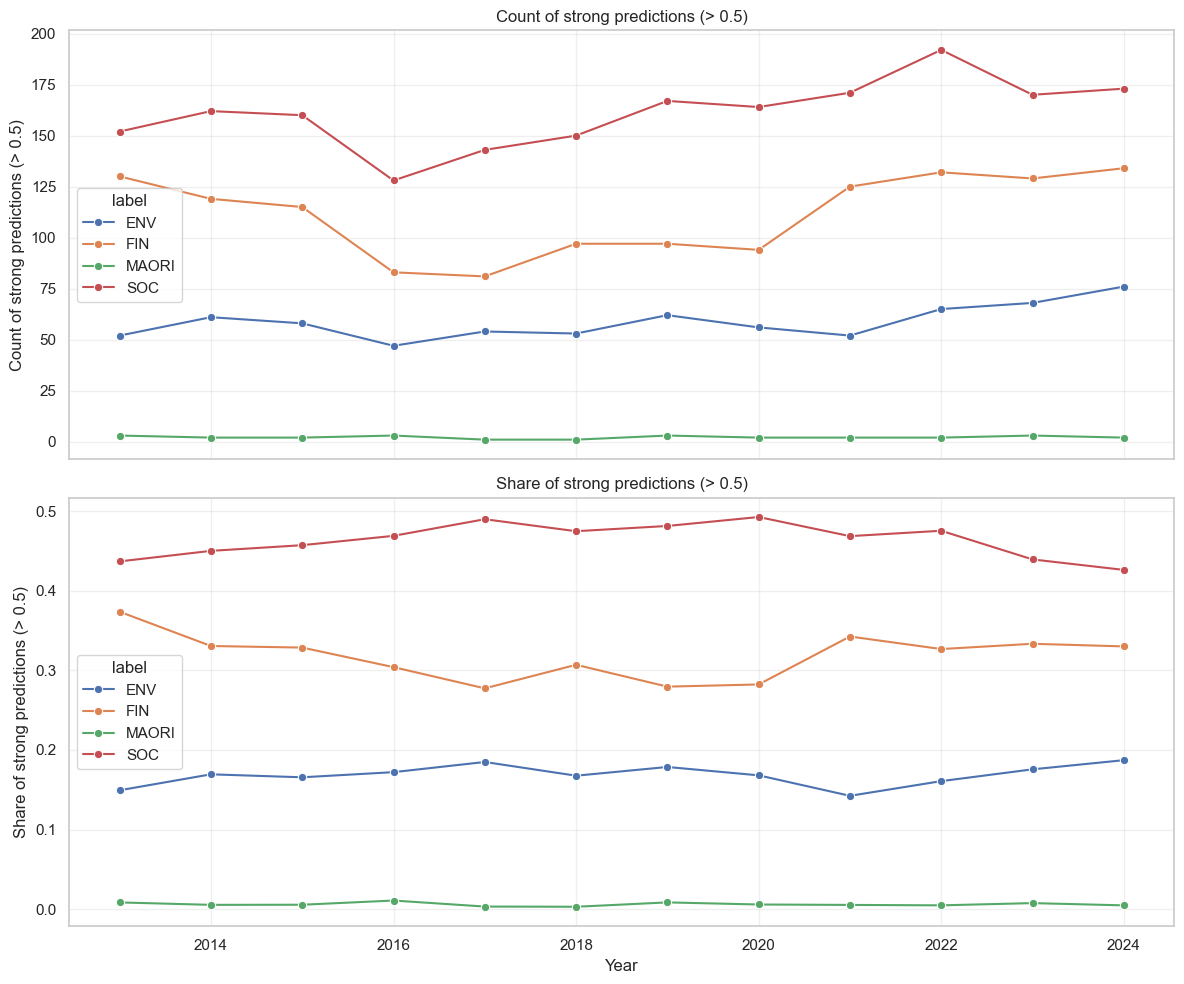

In [7]:
# Combined view for threshold > 0.5 (counts, shares)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plot_map = [
    ("over_count", "Count of strong predictions (> 0.5)"),
    ("over_share", "Share of strong predictions (> 0.5)")
]
summary = summaries[0.5]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


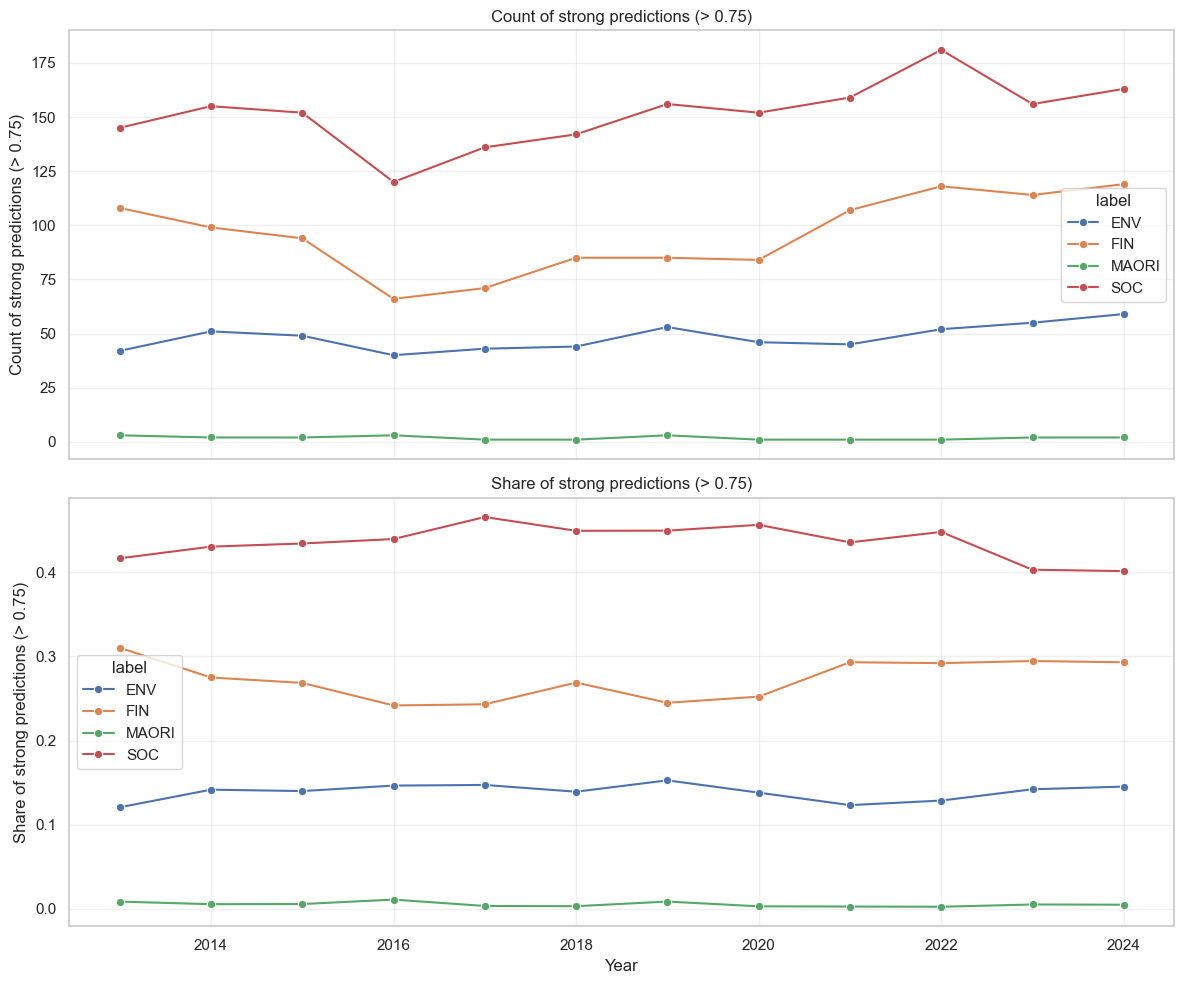

In [8]:
# Combined view for threshold > 0.75 
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plot_map = [
    ("over_count", "Count of strong predictions (> 0.75)"),
    ("over_share", "Share of strong predictions (> 0.75)")
]
summary = summaries[0.75]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


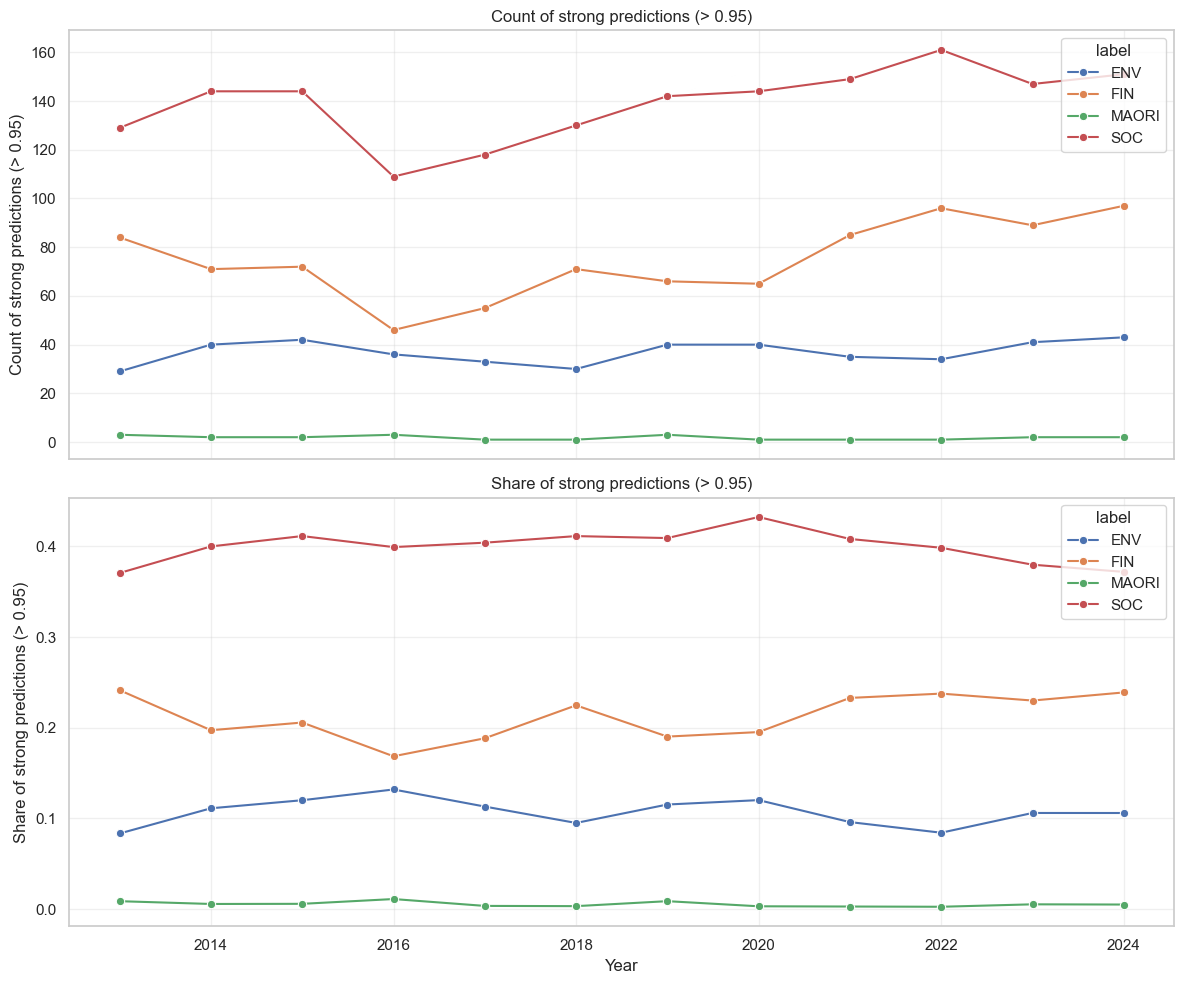

In [9]:
# Combined view for threshold > 0.95 
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plot_map = [
    ("over_count", "Count of strong predictions (> 0.95)"),
    ("over_share", "Share of strong predictions (> 0.95)")
]
summary = summaries[0.95]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


Notes
- over_count: how many sentences per label per year with predicted probability above the chosen threshold.
- over_share: same as over_count / total sentences for that year+label (proportion of strong predictions).
- mean_prob_over: average probability for those sentences above the threshold (0 if none above threshold).
